<h2><font color="#004D7F" size=6>Módulo 4. Fase de tratamiento de datos</font></h2>



<h1><font color="#004D7F" size=5>4. Feature Selection con datos categóricos</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Machine Learning con Python</font><br>

---

<h2><font color="#004D7F" size=5>Índice</font></h2>
<a id="indice"></a>

* [1. Introducción](#section1)
    * [1.1. Librerías](#section11)
    * [1.2. Dataset](#section12)
    * [1.3. Prepración de datos](#section13)
* [2. Codificaicón de variables](#section2)
    * [2.1. Codificación ordinal](#section21)
    * [2.2. Codifiación de target](#section22)
    * [2.3. Codificación del dataset](#section23)
* [3. Feature Selection](#section3)
    * [3.1. Chi-Cuadrado](#section31)
    * [3.2. Información mútua](#section32)
* [4. Modelado](#section4)
    * [4.1. Resultados de línea base](#section41)
    * [4.2. Resultados con Chi-cuadrado](#section42)
    * [4.3. Resultados con Información mutua](#section43)

In [ ]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes)
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:98% }</style>"))

---

<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción</font>

En resumen, feature selection, también llamado como selección de mejores características o atributos, es el proceso de seleccionar un subconjunto de características pertinentes (variables, predictores) para su uso en construcción de modelos. Las técnicas de feature selection son utilizadas por cuatro razones:
* Simplificación de modelos con el fin de hacerlas más sencillas de interpretar para los usuarios/investigadores.
* Menor tiempo de entrenamiento.
* Evitar la maldición de la dimensionalidad:
* Generalización realzada por reducir _overfitting_ (formalmente, reducción de varianza).

Los dos métodos de selección de características más utilizados para datos de entrada categóricos cuando la variable objetivo también es categórica (por ejemplo, modelo predictivo de clasificación) son la **estadística de Chi-cuadrado** y la **estadística de información mutua**.

Veamos como es para este tipo de datos muy típico en problemas de Machine Learning.

<a id="section11"></a>
## <font color="#004D7F"> 1.1. Librerías</font>

Por último vamos a declarar algunas librerías generales que ya hemos estado trabajando y que usaremos a lo largo de la sección.

In [48]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

<a id="section12"></a>
## <font color="#004D7F"> 1.2. Dataset</font>

Como base de este tutorial, usaremos el llamado "[Breast Cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer)". El conjunto de datos clasifica los datos de pacientes con cáncer de mama como una recurrencia o sin recurrencia del cáncer. Hay 286 ejemplos y nueve variables de entrada. Es un problema de clasificación binaria.

Un modelo ingenuo puede lograr una precisión del 70% en este conjunto de datos. Una buena puntuación es de aproximadamente 76% +/- 3%. Apuntaremos a esta región, pero tenga en cuenta que los modelos de este tutorial no están optimizados; están diseñados para demostrar esquemas de codificación.

Al observar los datos, podemos ver que las nueve variables de entrada son categóricas.

In [22]:
def load_dataset(filename):
    data = pd.read_csv(filename, header=None)
    dataset = data.values
    X = dataset[:, :-1]
    y = dataset[:,-1]
    # formateamos todos a str por si alguno lo traduce a numérico automáticamente
    X = X.astype(str)
    return X, y

In [24]:
X, y = load_dataset('data/breast-cancer.csv')

<a id="section13"></a>
## <font color="#004D7F"> 1.3. Prepración de datos</font>

Dividimos el dataset para entrenamiento validación con un Hold-out del 77%/33%

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (191, 9) (191,)
Test (95, 9) (95,)


<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section2"></a>
# <font color="#004D7F"> 2. Codificación de variables</font>

Podemos usar [`OrdinalEncoder()` de scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) para codificar cada variable en números enteros. Esta es una clase flexible y permite especificar el orden de las categorías como argumentos si se conoce dicho orden.

La mejor práctica al codificar variables es ajustar la codificación en el conjunto de datos de entrenamiento y luego aplicarla a los conjuntos de datos de entrenamiento y validación.

<a id="section21"></a>
## <font color="#004D7F"> 2.1. Codificación ordinal </font>

La función a continuación denominada `prepare_inputs()` toma los datos de entrada para el entrenamiento y validación y los codifica usando una codificación ordinal.

In [26]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

<a id="section22"></a>
## <font color="#004D7F"> 2.2. Codifiación de target</font>

También necesitamos preparar la variable objetivo. Es un problema de clasificación binaria, por lo que necesitamos asignar las dos etiquetas de clase a 0 y 1. Este es un tipo de codificación ordinal, y scikit-learn proporciona la clase [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) diseñada específicamente para este propósito. Podríamos usar `OrdinalEncoder` con la misma facilidad y lograr el mismo resultado, aunque `LabelEncoder` está diseñado para codificar una sola variable.

La función `prepare_targets()` entero codifica los datos de salida para el tren y los conjuntos de prueba.

In [27]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

<a id="section23"></a>
## <font color="#004D7F"> 2.3. Codificación del dataset</font>

Finalmente, codificamos todo el datset al completo.

Una vez codificado todo el dataset podemos realizar Feature Selection a nuestro dataset.

In [34]:
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

print(X_train_enc)
print()
print(y_train_enc)

[[ 3.  0.  4. ...  0.  3.  0.]
 [ 1.  2.  9. ...  0.  3.  0.]
 [ 3.  2. 10. ...  1.  2.  1.]
 ...
 [ 4.  0.  1. ...  1.  1.  0.]
 [ 4.  0.  7. ...  1.  1.  0.]
 [ 4.  0.  8. ...  0.  0.  0.]]

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1
 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0
 1 0 1 0 1 0]


<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section3"></a>
# <font color="#004D7F"> 3. Feature Selection </font>

Hay dos técnicas de selección de características populares que se pueden usar para datos de entrada categóricos y una variable de destino categórica (clase).
* Estadístico Chi-Cuadrado.
* Estadística de información mutua.

<a id="section31"></a>
## <font color="#004D7F"> 3.1. Chi-Cuadrado </font>

La prueba de hipótesis estadística de chi-cuadrado de Pearson es un ejemplo de una prueba de independencia entre variables categóricas. Los resultados de esta prueba se pueden usar para la selección de características, donde las características que son independientes de la variable de destino se pueden eliminar del conjunto de datos.

La librería de scikit-learn proporciona una implementación del test estadístico Chi-cuadrado en la función [`chi2()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html). Esta función se puede utilizar en una estrategia de selección de características, como seleccionar las *k* características más relevantes (valores más grandes) a través de la clase [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) .

Por ejemplo, podemos definir la clase `SelectKBest` para usar la función `chi2()` y seleccionar todas las características, luego transformar el tren y los conjuntos de prueba. Posteriormente, imprimimos los puntajes arrojados por el test estadístico

In [38]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Se crea un gráfico de barras de las puntuaciones de importancia de la característica para cada característica. Esto muestra claramente que la característica 3 podría ser la más relevante (según chi-cuadrado) y que quizás cuatro de las nueve características de entrada sean las más relevantes.

Podríamos establecer *k = 4* al configurar `SelectKBest` para seleccionar estas cuatro características principales.

Feature 0: 0.472553
Feature 1: 0.029193
Feature 2: 2.137658
Feature 3: 29.381059
Feature 4: 8.222601
Feature 5: 8.100183
Feature 6: 1.273822
Feature 7: 0.950682
Feature 8: 3.699989


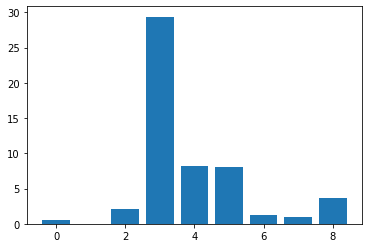

In [52]:
# realizamos FS
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

#Imprimimos los valore y los representamos
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

<a id="section32"></a>
## <font color="#004D7F"> 3.2. Información mútua </font>

La información mutua del campo de la teoría de la información es la aplicación de la ganancia de información (normalmente utilizada en la construcción de árboles de decisión) a la selección de características. La información mutua se calcula entre dos variables y mide la reducción de la incertidumbre para una variable dado un valor conocido de la otra variable.

La libería de scikit-learn proporciona una implementación de información mutua para la selección de características a través de la función [`mutual_info_classif()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html). Al igual que `chi2()`, se puede utilizar en la estrategia de selección de características `SelectKBest` (y otras estrategias).

In [43]:
def select_features2(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Al ejecutar el ejemplo, primero se imprimen las puntuaciones calculadas para cada característica de entrada y la variable target. En este caso, podemos ver que algunas de las características tienen una puntuación muy baja, lo que sugiere que quizás se puedan eliminar. Quizás las características 3, 6, 2 y 5 sean las más relevantes.

**Nota**: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o las diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y compare el resultado promedio.

Feature 0: 0.000000
Feature 1: 0.010636
Feature 2: 0.063814
Feature 3: 0.041706
Feature 4: 0.000000
Feature 5: 0.014018
Feature 6: 0.030975
Feature 7: 0.000000
Feature 8: 0.052069


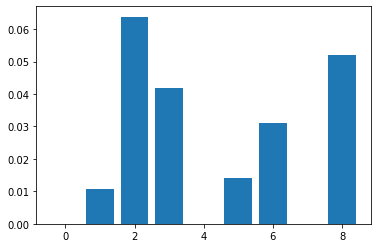

In [46]:
# realizamos FS
X_train_fs, X_test_fs, fs = select_features2(X_train_enc, y_train_enc, X_test_enc)

#Imprimimos los valore y los representamos
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section4"></a>
# <font color="#004D7F"> 4. Modelado </font>

Una vez transformado y conocido los resultados de FS, evaluaremos un modelo Logistic Regression (LoR) con todas las características en comparación con un modelo construido a partir de características seleccionadas por chi-cuadrado y esas características seleccionadas a través de información mutua.

LoR es un buen modelo para probar métodos de selección de características, ya que puede funcionar mejor si las características irrelevantes se eliminan del modelo.

<a id="section41"></a>
## <font color="#004D7F"> 4.1. Resultados de línea base </font>

Como primer paso, evaluaremos un modelo LogisticRegression utilizando todas las características disponibles. La ejecución del ejemplo imprime el Accuracy del modelo.

En este caso, podemos ver que el modelo logra un Accuracy de clasificación de alrededor del 76%. Preferiríamos utilizar un subconjunto de características que logre una precisión de clasificación tan buena o mejor que esta.

**Nota**: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o las diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y compare el resultado promedio.

In [49]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_enc, y_train_enc)

yhat = model.predict(X_test_enc)

accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 75.79


<a id="section42"></a>
## <font color="#004D7F"> 4.2. Resultados con Chi-cuadrado </font>

Primeros vamos a redefinir la función para que pueda escoger las 4 características con el puntaje más alto.

In [54]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k=4)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs

La ejecución del ejemplo informa el rendimiento del modelo en solo cuatro de las nueve características de entrada seleccionadas mediante la estadística de chi-cuadrado. En este caso, vemos que el modelo logró una precisión de alrededor del 74%, una ligera caída en el rendimiento.

Es posible que algunas de las características eliminadas estén, de hecho, agregando valor directamente o en concierto con las características seleccionadas. En esta etapa, probablemente preferiríamos utilizar todas las funciones de entrada.

**Nota**: Los resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o las diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y compare el resultado promedio. También puede ser una buena idea explorar el uso de la validación cruzada de k-fold en lugar de una simple división de tren / prueba.

In [55]:
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)

yhat = model.predict(X_test_fs)

accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 74.74


<a id="section43"></a>
## <font color="#004D7F"> 4.3. Resultados con Información mutua </font>

Primeros vamos a redefinir la función para que pueda escoger las 4 características con el puntaje más alto.

In [58]:
def select_features2(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=4)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs

Al ejecutar el ejemplo, el modelo se ajusta a las cuatro características seleccionadas principales elegidas utilizando información mutua.En este caso, podemos ver un pequeño aumento en la precisión de clasificación al 78%.

**Nota**: Los resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o las diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y compare el resultado promedio. También puede ser una buena idea explorar el uso de la validación cruzada de k-fold en lugar de una simple división de tren / prueba.

In [74]:
X_train_fs, X_test_fs = select_features2(X_train_enc, y_train_enc, X_test_enc)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)

yhat = model.predict(X_test_fs)

accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))



Accuracy: 77.89


<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>